#import Libraries

In [1]:
!pip install -U scikit-fuzzy

Requirement already up-to-date: scikit-fuzzy in c:\users\barka\anaconda3\lib\site-packages (0.4.2)


In [2]:
!pip install emojis 

In [3]:
!pip install vaderSentiment

In [1]:
import re
import os 
import nltk
import string
import emojis
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\barka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
emoji_table = pd.read_csv('ijstable - ijstable (1) (1).csv')
emoji_table['ord'] = emoji_table.Char.apply(ord)
emoji_table.head()

,Char,Unicode,Sentiment score,Unicode name,ord
0,😂,0x1f602,0.221,FACE WITH TEARS OF JOY,128514
1,❤,0x2764,0.746,HEAVY BLACK HEART,10084
2,♥,0x2665,0.657,BLACK HEART SUIT,9829
3,😍,0x1f60d,0.678,SMILING FACE WITH HEART-SHAPED EYES,128525
4,😭,0x1f62d,-0.093,LOUDLY CRYING FACE,128557


#Pre-processing  

 1. Split tweet to text, emoij, hashtag
 2. Tokenization
 3. Remove stopwords 
 5.	Remove special and non ASCII characters
 6.	Replace contractions with complete phrases (e.g.: "I'll" with "I will")
 7.	Expand Abbreviations and other urban lingos
 8.	Remove email addresses, URLs, twitter user handles, etc.











In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]_#')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
STOPWORDS = set(stopwords.words('english'))

def split_text(text):
    """
        text: a string   
        return: text, emoij, hashtag
    """
    emoij = emojis.get(text)
    hashtag = re.findall(r'#\S+', text) 
    hashtags = []
    if hashtag:
        for i in hashtag:
            i = re.sub(r'_|#',' ', i) 
            hashtags.append(i)
    text = re.sub('https?\S+', ' ', text) # remove URL
    text = re.sub(r"@\S+",'',text) # remove mantion
    text = re.sub(r'RT|cc', '', text) # remove RT | cc 
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = "".join([char for char in text if char not in string.punctuation]) # remove punctuation
    text = re.sub('\s+', ' ', text)  # remove extra whitespace

    


    text = re.sub(r'#\S+', '', text) # remove hashtags only removing the hash # sign from the word
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
 
    return text, emoij, hashtags

In [4]:
print(split_text('i am happy'))

('happy', set(), [])


#Apply analysis for text, emoij, hashtag

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def analysis_value(tweet):
    ana = {}
    split_tweet = split_text(tweet)
    ana['text']= SentimentIntensityAnalyzer().polarity_scores(split_tweet[0])['compound']
    ana['hashtag'] = SentimentIntensityAnalyzer().polarity_scores(split_tweet[2])['compound']
    sum = 0
    emoji_table['Sentiment score'].apply(lambda x: float(x))
    emoji = split_tweet[1]
    for em in emoji:
        if len(em)==1:
            row = emoji_table.loc[emoji_table['ord'] == ord(em)]
            if row.empty == False:
                sum = float(row.get('Sentiment score'))
            else:
                sum = 0.0
        else:
            em=em[0]
            row = emoji_table.loc[emoji_table['ord'] == ord(em)]
            if row.empty == False:
                sum = float(row.get('Sentiment score'))
            else:
                sum = 0.0
    if sum > 1:
        sum = 1
    elif sum<-1:
        sum = -1   
    ana['emoji'] = sum 
    
    return ana; 

# Apply fuzzy logic

C:\Users\barka\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


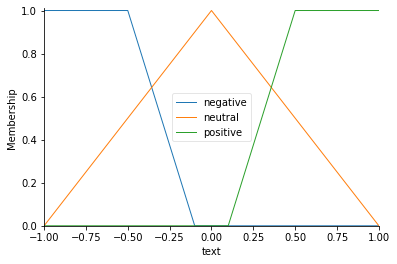

In [6]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# range input and output
text = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'text')
hashtag = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'hashtag')
emoji = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'emoji')

sentiment = ctrl.Consequent(np.arange(-1, 1.1, 0.1), 'sentiment')

# status input and output

text['negative'] = fuzz.trapmf(text.universe, [-1,-1, -0.5, -0.1])
text['neutral'] = fuzz.trimf(text.universe, [ -1,0, 1])
text['positive'] = fuzz.trapmf(text.universe, [0.1, 0.5,1, 1])


hashtag['negative'] = fuzz.trapmf(hashtag.universe, [-1,-1, -0.5, -0.1])
hashtag['neutral'] = fuzz.trimf(hashtag.universe, [ -1,0, 1])
hashtag['positive'] = fuzz.trapmf(hashtag.universe, [0.1, 0.5,1, 1])

emoji['negative'] = fuzz.trapmf(emoji.universe, [-1,-1, -0.5, -0.1])
emoji['neutral'] = fuzz.trimf(emoji.universe, [ -1,0, 1])
emoji['positive'] = fuzz.trapmf(emoji.universe, [0.1, 0.5,1, 1])

text.view()

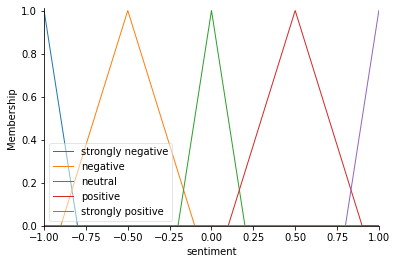

In [7]:
sentiment['strongly negative'] = fuzz.trimf(sentiment.universe, [-1,-1, -0.8])
sentiment['negative'] = fuzz.trimf(sentiment.universe, [-0.9,-0.5,-0.1])
sentiment['neutral'] = fuzz.trimf(sentiment.universe, [-0.2,0,0.2])
sentiment['positive'] = fuzz.trimf(sentiment.universe, [0.1,0.5,0.9])
sentiment['strongly positive'] = fuzz.trimf(sentiment.universe, [0.8,1,1])

sentiment.view()


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

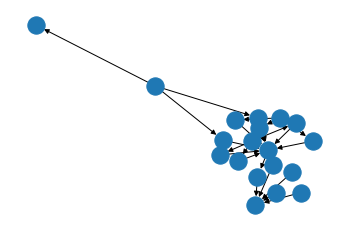

In [8]:
rule1 = ctrl.Rule(text['positive'] & hashtag['positive'] & emoji['positive']| text['positive'] & hashtag['neutral'] & emoji['positive'],
                  sentiment['strongly positive'])

rule2 = ctrl.Rule(text['positive'] & hashtag['positive'] & emoji['negative']|
                  text['positive'] & hashtag['negative'] & emoji['negative']| 
                  text['positive'] & hashtag['negative'] & emoji['positive']|
                  text['neutral'] & hashtag['neutral'] & emoji['positive']| 
                  text['neutral'] & hashtag['positive'] & emoji['neutral']|
                  text['neutral'] & hashtag['positive'] & emoji['positive']|
                  text['positive'] & hashtag['neutral'] & emoji['neutral']|
                  text['positive'] & hashtag['positive'] & emoji['neutral'],
                  sentiment['positive'])

rule3 = ctrl.Rule(hashtag['neutral'] & text['neutral'] & emoji['neutral'],
                  sentiment['neutral'])
                  
rule4 = ctrl.Rule(text['negative'] & hashtag['positive'] & emoji['negative']|text['negative'] & hashtag['negative'] & emoji['positive']|
                  text['negative'] & hashtag['negative'] & emoji['neutral']| text['neutral'] & hashtag['negative'] & emoji['neutral']|
                  text['neutral'] & hashtag['neutral'] & emoji['negative']| text['negative'] & hashtag['neutral'] & emoji['neutral']|
                  text['neutral'] & hashtag['negative'] & emoji['negative']| text['negative'] & hashtag['positive'] & emoji['positive'],
                  sentiment['negative'])

rule5 = ctrl.Rule(text['negative'] & hashtag['negative'] & emoji['negative']| text['negative'] & hashtag['neutral'] & emoji['negative'],
                  sentiment['strongly negative'])
rule2.view()

In [9]:
bot = ctrl.ControlSystem([rule1,rule2,rule3,rule4,rule5])
bot= ctrl.ControlSystemSimulation(bot)

# test

In [12]:
tweet1="#Bitcoin is the key to a brighter future🚀🚀!! U just can't compare mathematical #Bitcoin with physical gold, nor political fiat It's simply something completely different and trustful!" 
tweet2=" i m scared "

In [13]:
dic_tweet= analysis_value(tweet2)
dic_tweet

{'text': -0.4404, 'hashtag': 0.0, 'emoji': 0}

0.4930164316707894


C:\Users\barka\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


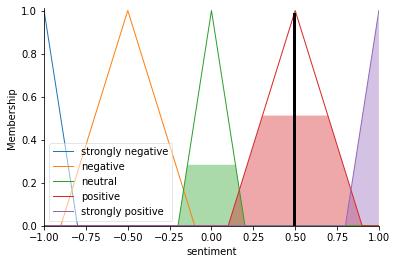

In [28]:
bot.input['text'] = dic_tweet['text']
bot.input['hashtag'] = dic_tweet['hashtag']
bot.input['emoji'] = dic_tweet['emoji']
# Crunch the numbers
bot.compute()

"""n                                                                                                                                                                                                                           
Once computed, we can view the result as well as visualize it.
"""
print(bot.output['sentiment'])
sentiment.view(sim=bot)

In [54]:
%run twitter_data.ipynb

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pytz; python_version < "3.9.0" in c:\users\barka\anaconda3\lib\site-packages (from snscrape) (2020.1)



Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping after 20 empty pages
Stopping a

562 duplicate rows dropped!
Current row count: 7660




In [70]:
tweets_df.head(100)

,Date,Text,user
29,2021-05-31 19:14:37+00:00,"While CT argues over nonsense, $BTC is getting...",CryptoCapo_
0,2021-06-01 01:01:43+00:00,5 years ago today. \n\n1 #BTC 🤝 $526.23\n1 $ET...,MiAiimii
85,2021-06-01 02:32:13+00:00,[Listing] Verasity(VRA) KRW/BTC market listing...,BithumbOfficial
49,2021-06-01 02:52:41+00:00,Bitcoin ETF SEC V Ripple Settlement Flare Drop...,digitalassetbuy
88,2021-06-01 02:59:19+00:00,Musk: I'm perfecting the electric car...\nMe: ...,HeerJeet
...,...,...,...
184,2021-06-02 11:47:24+00:00,I am in Miami and ready to stack sats on the g...,Breedlove22
153,2021-06-02 11:48:42+00:00,A boy asked his bitcoin-investing dad for 1 bi...,KingiJosh
115,2021-06-02 12:01:16+00:00,"“I fear not the man who has practiced 10,000 k...",saylor
118,2021-06-02 12:06:43+00:00,Yeah BTC is about to fucking explode lol. Watc...,ksicrypto


In [56]:
liste=[]
for key,value in tweets_df.Text.iteritems():
    dic_tweets= analysis_value(str(tweets_df.Text[key]))
    liste.append(dic_tweets)
print(len(liste))

7660


In [57]:
l=[]
for dic_tweets in liste:
    bot.input['text'] = dic_tweets['text']
    bot.input['hashtag'] = dic_tweets['hashtag']
    bot.input['emoji'] = dic_tweets['emoji']
    bot.compute()
    l.append(bot.output['sentiment'])
print(len(l))        

7660


In [58]:
l

[-0.35022859671065326,
 1.8070036208091727e-17,
 0.34278642018801103,
 -0.2972817331998541,
 0.4621808643521534,
 1.8070036208091727e-17,
 0.3540638650465042,
 -0.33667374949750184,
 2.459161840788177e-17,
 0.3870651834660603,
 1.8070036208091727e-17,
 -0.31920949200579174,
 -0.3540638650465043,
 0.3798131997103642,
 -0.013036618304881542,
 0.3622978054919676,
 0.37491741671058615,
 -0.3540638650465043,
 -0.42893102795258664,
 0.5843569425753572,
 0.3346085361139125,
 1.8070036208091727e-17,
 0.3527336476829973,
 1.8070036208091727e-17,
 1.8070036208091727e-17,
 -0.3574022029007016,
 1.8070036208091727e-17,
 0.36758268000634176,
 2.6903997106088508e-17,
 0.3346085361139125,
 1.8070036208091727e-17,
 1.8070036208091727e-17,
 0.38947262627334905,
 0.3870651834660603,
 -0.35022859671065326,
 0.3628132837382121,
 0.36611532844956574,
 0.38466908726638704,
 -0.1883079412944845,
 0.35371700431363734,
 1.8070036208091727e-17,
 1.8070036208091727e-17,
 -0.4648542834845858,
 1.8070036208091727e

In [62]:
d=tweets_df['Date']
column_values = pd.Series (l, name='sentiment_score')
df= pd.concat([d, column_values], axis=1)
df.head(10)

,Date,sentiment_score
0,2021-06-01 01:01:43+00:00,-3.502286e-01
1,2021-06-01 16:42:54+00:00,1.807004e-17
2,2021-06-01 15:03:23+00:00,3.427864e-01
3,2021-06-01 11:38:22+00:00,-2.972817e-01
4,2021-06-01 23:41:16+00:00,4.621809e-01
5,NaT,1.807004e-17
6,2021-06-01 08:15:36+00:00,3.540639e-01
7,2021-06-01 15:02:52+00:00,-3.366737e-01
8,2021-06-01 14:18:34+00:00,2.459162e-17
9,2021-06-01 13:00:56+00:00,3.870652e-01


C:\Users\barka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='sentiment_score'>

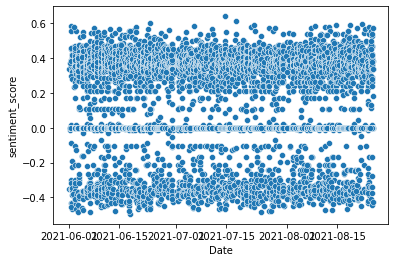

In [63]:
sns.scatterplot(df['Date'],df['sentiment_score'])

In [64]:
df = df.assign(Date = lambda x: pd.to_datetime(x['Date'].dt.strftime('%Y-%m-%d')))
sentiment_score= df.groupby(['Date'], as_index=False).mean({'sentiment_score'})
sentiment_score.head(100)

,Date,sentiment_score
0,2021-05-31,0.334609
1,2021-06-01,0.072075
2,2021-06-02,0.133549
3,2021-06-03,0.157839
4,2021-06-04,0.152309
...,...,...
87,2021-08-26,NaN
88,2021-08-27,NaN
89,2021-08-28,NaN
90,2021-08-29,NaN


In [65]:
sentiment_score['sentiment_score']=sentiment_score['sentiment_score'].shift(1)
sentiment_score

,Date,sentiment_score
0,2021-05-31,NaN
1,2021-06-01,0.334609
2,2021-06-02,0.072075
3,2021-06-03,0.133549
4,2021-06-04,0.157839
...,...,...
87,2021-08-26,NaN
88,2021-08-27,NaN
89,2021-08-28,NaN
90,2021-08-29,NaN


C:\Users\barka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='sentiment_score'>

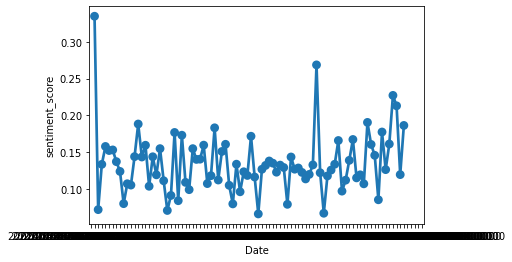

In [66]:
sns.scatterplot(sentiment_score['Date'], sentiment_score['sentiment_score'])
sns.pointplot(x = "Date", y = "sentiment_score", data = sentiment_score)

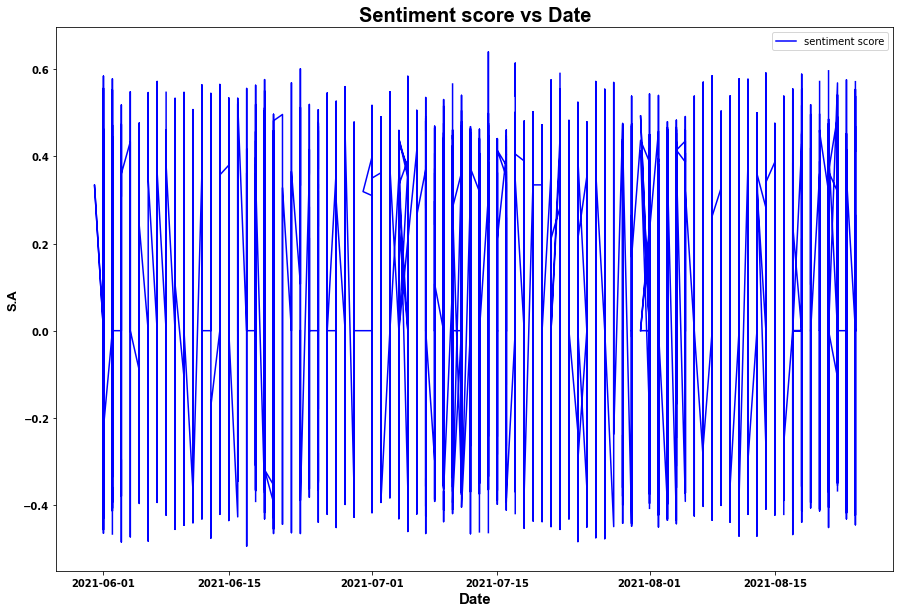

In [67]:
fig = plt.figure(figsize=[15,10])


plt.title('Sentiment score vs Date', fontfamily = 'arial', fontsize=20,fontweight='bold', color= 'black')

plt.plot(df.Date,df.sentiment_score,  label='sentiment score', color ='blue')
plt.xlabel('Date',fontfamily = 'arial', fontsize=15, fontweight= 'bold')
plt.ylabel('S.A',fontfamily = 'arial', fontsize=13,fontweight= 'bold')
plt.xticks(size=10,fontweight= 'bold')
plt.yticks(size=10,fontweight= 'bold')
plt.legend()

plt.show()

In [69]:
sentiment_score.to_csv("C:/Users/barka/OneDrive/Bureau/sentiment_score1.csv")